# **Metody interpretowalności dla sieci neuronowych**
Autor: Anna Dawid

## Wprowadzenie
Ogólna zasada jest taka, że im bardziej skomplikowana sieć (model), tym bardziej złożone problemy potrafi opisać (co jest dość intuicyjne). Wiąże się z tym pewna komplikacja w postaci utraty interpretowalności wraz ze wzrastającym poziomem złożoności modelu.

### Po co w ogóle się przejmować interpretowalnością?

* ulepszanie modelu -> gdy przeanalizujemy na co zwraca uwagę podczas klasyfikacji i regresji, i dowiemy się, że skupia się na niezbyt istotnej cesze, możemy spróbować ulepszyć model. Przykład: **[obraz](http://3.bp.blogspot.com/-S8g8SNWhyR0/WIsOFqPD2WI/AAAAAAAAA68/9yNFp6sdao0Er7qDIqEPu7ORTU589tFCACK4B/s1600/Bildschirmfoto%2B2017-01-27%2Bum%2B10.08.11.png): pies husky na śniegu => predykcja: wilk**


* powody etyczne: zapobieganie dyskryminacji wdrukowanej przez człowieka opisującego dane treningowe oraz modele stosowane do celów medycznych
* powody prawne: od maja 2019 r. każdy obywatel Unii ma prawo poznać rozumowanie stojące za każdą zautomatyzowaną, dotyczącą go decyzją
* jedyny sposób, żeby uczenie maszynowe nauczyło nas czegoś nowego o fizyce?

Przykłady interpretowalnych modeli, które poznaliśmy na zajęciach: regresja logistyczna, drzewa decyzyjne, do pewnego stopnia maszyny wektorów wspierających

Sztandarowym przykładem bogatego modelu nieinterpretowalnego są głębokie sieci neuronowe (w tym konwolucyjne, szczególnie skuteczne w analizie obrazków).

## Jakie mamy metody?

Baaaaaardzo dużo. W ogólności można je podzielić na trzy kategorie (choć nie wyczerpuje to tematu! Dziedzina interpretowalnego uczenia maszynowego produkuje kilka nowych metod co tydzień!).

Można zadać sobie następujące pytania:
1. Jaki input, jakie dane wejściowe maksymalnie aktywują neuron odpowiadający predykcji konkretnej klasy? Czyli jak wygląda według modelu archetypowy pies/kot/dziewiątka? Przykłady: wizualizacja cech (feature visualisation), zainteresowani mogą wygooglować DeepDream
2. Czy możemy lokalnie zastąpić ten model prostszym, za to interpretowalnym? Przykłady: [LIME](https://towardsdatascience.com/understanding-model-predictions-with-lime-a582fdff3a3b).
3. Która część danych wejściowych (np. która część obrazka) była najbardziej odpowiedzialna za daną predykcję? Przykłady: [mapy ciepła](https://towardsdatascience.com/demystifying-convolutional-neural-networks-using-class-activation-maps-fe94eda4cef1)

Część takich metod jest zebrana w ładnych bibliotekach np. [iNNvestigate](https://github.com/albermax/innvestigate/blob/master/examples/notebooks/mnist_compare_methods.ipynb) lub [Alibi](https://github.com/SeldonIO/alibi).


W ramach dzisiejszych ćwiczeń poznamy i pobawimy się podstawową metodą interpretowalności z kategorii 3, czyli mapami aktywacji klasy (CAM, Class Activation Maps, [publikacja](https://arxiv.org/pdf/1512.04150.pdf)). Mają wiele pochodnych i udoskonaleń (np. [Grad-CAM](https://jacobgil.github.io/deeplearning/class-activation-maps)), zbiorczo takie mapy nazywa się czasem mapami ciepła.

# Class Activation Maps (CAM)

Kod bazuje na [kodzie stworzonym przez autorów metody](https://github.com/zhoubolei/CAM).

![CAM](https://drive.google.com/uc?id=1vibsld9iq7j4GYgDP5LMXdoitvfr8q_M)

## Zaczniemy od importu wytrenowanej i skomplikowanej sieci **z GAP na końcu**

Żeby było więcej zabawy, będziemy dzisiaj sprawdzać mapy ciepła na obrazkach ze zbioru ImageNet. To zbiór ponad 14 milionów zdjęć z [1000](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a) kategorii (a dokładniej z 1000 nienachodzących na siebie kategorii, generalnie wylicza się tam 20 000 kategorii, ale wyścigi sieci neuronowych robi się na tych rozłącznych).

Zaprojektowanie od zera skutecznej sieci rozpoznającej tyle obiektów byłoby trudne i czasochłonne (głównie czasochłonne), więc stańmy na ramionach olbrzymów :)

In [1]:
import io
import requests
from PIL import Image
# from google.colab.patches import cv2_imshow
from cv2 import imshow
from torchvision import models, transforms
from torch.autograd import Variable
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pdb

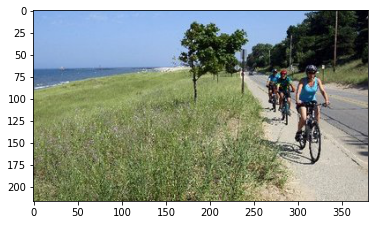

In [2]:
# obrazek do analizy
IMG_URL = 'http://media.mlive.com/news_impact/photo/9933031-large.jpg'
LABELS_URL = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
# wydrukuj obrazek
response = requests.get(IMG_URL)
img_pil = Image.open(io.BytesIO(response.content))
plt.imshow(img_pil)

In [3]:
# Jeśli chcesz zapisywać wyniki, potrzebujesz podłączyć dysk Google'a
# from google.colab import drive
# drive.mount('/content/drive/')
# folder = '/content/drive/My Drive/Colab Notebooks/'

folder='./' # <-- do pracy lokalnej, zakomentuj jeżeli pracujesz na Collabie
response = requests.get(IMG_URL)
img_pil = Image.open(io.BytesIO(response.content))
img_pil.save(folder + 'test.jpg')

Zastanówmy się nad modelem, którego będziemy używali. Wydrukujmy sobie jego architekturę.
Pamiętajcie, dla podstawowego CAMa, konieczna jest globalna warstwa uśredniająca (global average pooling, GAP)!
Każdy skonwolutowany obrazek musi odpowiadać tylko jednej wartości w pełni-połączonej ostatniej warstwie!
Sieci takie jak GoogleNet, ResNet, DenseNet mają wbudowanego GAPa na końcu, więc można na nich zastosować CAM bez żadnych modyfikacji.
Tak wyglądają ich architektury: https://neurohive.io/en/popular-networks/


#### Zwróć uwagę, że definiujemy tu zmienną "finalconv_name"

In [34]:
# można wybrać architekturę tutaj
model_id = 2 # 1 = SqueezeNet, 2 = ResNet18, 3 = DenseNet161

if model_id == 1:
    net = models.squeezenet1_1(pretrained=True)
    finalconv_name = 'features' # to ostatnia warstwa konwolucyjna modelu
elif model_id == 2:
    net = models.resnet18(pretrained=True)
    finalconv_name = 'layer4'
elif model_id == 3:
    net = models.densenet161(pretrained=True)
    finalconv_name = 'features'

print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### Jeżeli powyżej dostałeś błąd SSL to spróbuj odkomentować i uruchomić poniższą komórkę, a następnie jeszcze raz tą powyżej.

In [26]:
# import ssl

# try:
#     _create_unverified_https_context = ssl._create_unverified_context
# except AttributeError:
#     # Legacy Python that doesn't verify HTTPS certificates by default
#     pass
# else:
#     # Handle target environment that doesn't support HTTPS verification
#     ssl._create_default_https_context = _create_unverified_https_context


In [33]:
# Ustaw już wytrenowaną sieć do trybu ewaluacji
net.eval()
print()

#### Teraz coś nietrywalnego. 

"Zaczepimy się" na konkretnej warstwie sieci. 
To znaczy, że nasz hak będzie zawierał wartości, które pojawiają się w "zaczepionej" warstwie. 
Także kiedy zrobimy predykcję na obrazku testowym za pomocą naszego modelu, 
to hak będzie zawierał elementy przetworzonego przez sieć obrazka, które się tam pojawią.
Nazwa ostatniej warstwy sieci zależy od wybranego modelu. W komórce gdzie wybieraliśmy model, 
także zdefiniowaliśmy 'finalconv_name', którą Wam wcześniej sprawdziłam z architektury.
Bierzemy więc tu te pojedyncze wartości, do których GAP sprowadza każdy skonwolutowany obrazek.


In [7]:
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())

net._modules.get(finalconv_name).register_forward_hook(hook_feature)

Tutaj wyciągamy wagi, które pojawiają się podczas klasyfikacji, przy softmaxie 
(po stronie GAPa, stąd 'params[-2]', czyli druga od końca)


In [8]:
params = list(net.parameters())
weight_softmax = np.squeeze(params[-2].data.numpy())

In [9]:
def returnCAM(feature_conv, weight_softmax, class_idx):
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam

#### Abu móc naszymi sieciami klasyfikować dowolny obrazek, musimy go najpierw trochę przeprocesować.

Mianowicie: 

    1) Zmienić wymiar do (224, 224), aby pasowało do wymiarów naszych sieci.

    2) Przetransformować dane do formatu zwanego "Tensorem" używanym przez PyTorch.

    3) Znormalizować obrazek zgodnie ze średnią i odchyleniem standardowym danych treningowych w zestawie ImageNet (na których trenowane były wszystkie modele) .



In [10]:
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225])

preprocess = transforms.Compose([
   transforms.Resize((224,224)),
   transforms.ToTensor(),
   normalize])

In [11]:
img_tensor = preprocess(img_pil)
img_variable = Variable(img_tensor.unsqueeze(0))

# Teraz predykcja! Hak przyczepiony do ostatniej warstwy konwolucyjnej zapamięta do czego skolapsował obrazek.
logit = net(img_variable)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [31]:
# odpalenie tej komórki stworzy i zapisze obrazek przedstawiający architekturę sieci Nauronowej, której używamy

## !pip3 install torchviz # <-- odpal jeżeli nie masz torchviz zainstalowanego
# from torchviz import make_dot

# make_dot(logit, params=dict(list(net.named_parameters()))).render("nn", format="png")

Mamy predykcje dla wszystkich etykietek, ale teraz musimy:
1) puścić to przez funkcję softmax, 

2) znaleźć największą wartość (~prawdopodobieństwo)

3) znaleźć do jakiej etykietki należy ta największa wartość


In [12]:
# Pobierz listę kategorii ImageNetu do słownika:
classes = {int(key):value for (key, value)
          in requests.get(LABELS_URL).json().items()}

# Puszczamy przez softmax:
h_x = F.softmax(logit, dim=1).data.squeeze()

# Sortujemy prawdopodobieństwa wraz z odpowiadającymi im kategoriami
probs, idx = h_x.sort(0, True)
probs = probs.numpy()
idx = idx.numpy()

# Output! (tutaj 5 etykietek z największymi prawdopodobieństwami)
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))

0.437 -> ['n03792782', 'mountain_bike']
0.131 -> ['n09193705', 'alp']
0.119 -> ['n02835271', 'bicycle-built-for-two']
0.108 -> ['n04509417', 'unicycle']
0.049 -> ['n09332890', 'lakeside']


In [41]:
# Wreszcie możemy wygenerować CAM dla dowolnej kategorii.
# Zacznijmy od klasy z największym prawdopodobieństwem, czyli top1: idx[0] (bo sortowaliśmy względem prawdopodobieństw, pamiętacie?)
CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[0]])

output CAM.jpg for the top1 prediction: ['n03792782', 'mountain_bike']


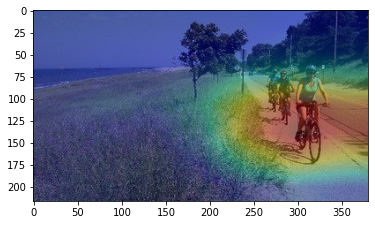

In [42]:
%matplotlib inline

# Wydrukuj CAM

print('output CAM.jpg for the top1 prediction: %s'%classes[idx[0]])
img = cv2.imread(folder + 'test.jpg')
height, width, _ = img.shape
heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
result = heatmap * 0.3 + img * 0.5 # nakładamy obrazek i heatmap na siebi
cv2.imwrite(folder + 'CAM.jpg', result) # zapisujemy na dysk

plt.imshow(np.flip(result/255, axis=-1) )# wyświetlamy jako obraz RGB (flip zmienia BGR nad RGB)
plt.show()

# Do samodzielnego zrobienia:

## Zadania numeryczne:
1. Metodą "kopiuj-wklej" stwórz funkcję, która za argument przyjmuje ścieżkę do obrazka z dysku, a zwraca mapę aktywacji odpowiedniej klasy.

2. Wydrukuj i zastanów się nad kształtem kolejno: 
*   obrazka wprowadzanego do sieci
*   outputem sieci
*   rozmiarem ostatniej warstwy (po GAP)
*   co funkcja CAM dokładnie robi? Czym jest 'weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))', dlaczego potem wynik jest reshape'owany do (h, w)? Czym są 'bz, nc, h, w'? Wydrukuj je wszystkie.
*   co robi cv2.resize? Czemu go potrzebujemy?

## Dyskusja:
1. Zastosuj do kilku obrazków z internetu i zastanów się, co mapy mówią Ci o odpowiednich predykcjach sieci.
2. Zastosuj do kilku obrazków z internetu z tej samej kategorii (np. różne psy, różne koty) i znów zastanów się, co mapy mówią Ci o odpowiednich predykcjach sieci.
3. Bazując na klasyfikacji metod opisanej podczas części wykładowej, do jakiej kategorii należy CAM?
  *   Jest zależny (model-specific) czy niezależny od modelu (model-agnostic)?
  *   Daje lokalne czy globalne wyjaśnienia modelu?
  *   Czy to (a) podejście surogatkowe? (b) metoda skupiająca się na analizie elementów składowych modelu? (c) metoda skupiająca się na analizie modelu po zaburzeniu danych wejściowych?


